# Exercise 2 - The Right Fit (25 Points)

In this exercise you will learn about a new type of regression - the polynomial regression. With polynomial regression it is possible to fit a nonlinear relationship between the dependent and the independent variables, although the problem of estimating the parameters is linear and can be solved with the standard OLS approach.

The idea here is to learn a bunch of (polynomial) models on the same data set and explore the meaning of over- and underfitting the data.

In a second part, we will use Leave One Out Crossvalidation to find a good regularization parameter on the Boston Housing dataset.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- paul.kahlmeyer@uni-jena.de

### Submission

- Deadline of submission:
        05.05.2021

## Dataset
We now have a new dataset saved as `train.npy`.

### Task 1 (1 Point)
Load this Dataset using the [`np.load`](https://numpy.org/doc/stable/reference/generated/numpy.load.html) function.

In [1]:
# TODO: load train.npy
import numpy as np
data = np.load("train.npy")

Columns of the dataset represent the variables. Let `X` be the explanatory variable in the first column and `Y` be the variable we want to predict in the second column. 

### Task 2 (1 Point)
Visualize the data with a scatterplot of `X` against `Y`.

Text(0, 0.5, 'Y')

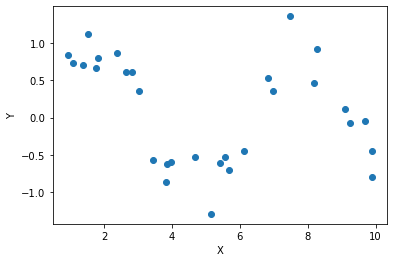

In [4]:
# TODO: scatter plot the data
from matplotlib import pyplot as plt

X = data[:,0]
Y = data[:,1]
plt.scatter(X, Y)
plt.xlabel("X")
plt.ylabel("Y")

## Polynomial Regression
As you can see, the relationship between the dependent variable and the explanatory one does not seem to be linear and the standard linear regression from the lecture will not perform well. One way to account for such a non linear relationship is called [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression). For a scalar explanatory variable `X` and a scalar dependent variable `Y`, the data generation model is:

$$
Y_i = \theta_0 + \theta_1 * X_i + \theta_2 X_i^2 + \dots + \theta_d X_i^d  + \epsilon_i = \sum_{j=0}^d \theta_i * X_i^j + \epsilon_i
$$
where $d$ is called degree. Although the relationship between the dependent and the explanatory variable is non linear, the problem of estimating the parameters $\theta$ is linear. By vectorizing the model, this becomes obvious:

$$
\begin{bmatrix}
    Y_1 \\
    Y_2 \\
    \vdots \\
    Y_n
\end{bmatrix}
=
\begin{bmatrix}
    \theta_0 \\
    \theta_1 \\
    \vdots \\
    \theta_d
\end{bmatrix}^T
\begin{bmatrix}
    1 & 1 & \dots & 1\\
    X_1 & X_2 & \dots & X_n\\
    \vdots&\vdots&\vdots&\vdots\\
    X_1^d & X_2^d &\dots & X_n^d
\end{bmatrix}
+
\begin{bmatrix}
    \epsilon_1 \\
    \epsilon_2 \\
    \vdots \\
    \epsilon_n
\end{bmatrix}
$$

This linear model can now be fit with the ordinary-least-squares MLE approach. 

### Task 3 (2 Points)
Implement a function `poly` to create the design matrix for the polynomial regression. It should take two arguments:
- `X` : dataset $X_1,\dots,X_n$
- `degree`: degree of polynomial ($d$ from above definition)

and return the design matrix from the above definition. 

Verify the correctness of your implementation!

In [6]:
def poly(x, degree):
    #TODO: return polynomial design matrix
    return np.vander(x, degree+1, increasing=True).T

x = np.array([1,2,3])
poly(x,3)

array([[ 1,  1,  1],
       [ 1,  2,  3],
       [ 1,  4,  9],
       [ 1,  8, 27]])

### Task 4 (3 Points)
Implement a class `PolyReg` that fits a polynomial model with ordinary least squares. Regularize your maximum-likelihood problem with ridge regression. The function returns the parameter vector.

Hint: Recycle the `LinReg` class from the last exercise.

In [34]:
class PolyReg():
    def __init__(self, d, c=0):
        # TODO: create attributes d, c, theta 
        self.d = d
        self.c = c
        self.theta = None
    
    def fit(self, X, Y):
        # TODO: estimate theta
        pX = poly(X, self.d)
        self.theta = np.linalg.solve((pX @ pX.T) + self.c*np.eye(pX.shape[0]), pX @ Y) # good
        #self.theta = np.linalg.inv((pX @ pX.T) + self.c*np.eye(pX.shape[0])) @ pX @ Y # bad
        
    def predict(self, X):
        # TODO: predict labels
        return self.theta @ poly(X, self.d)

### Why you should not use inverse directly

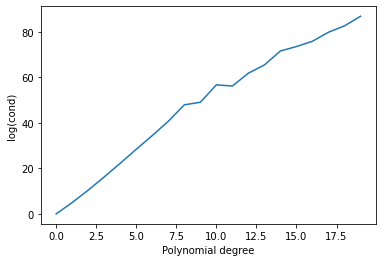

In [8]:
cond_numbers = []
for i in range(20):
    pX = poly(X,i)
    tmp = pX@pX.T
    cond_numbers.append(np.log(np.linalg.cond(tmp)))
    
plt.xlabel('Polynomial degree')
plt.ylabel('log(cond)')
plt.plot(cond_numbers)

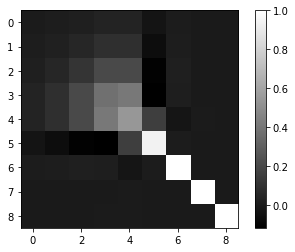

In [14]:
pX = poly(X,8)
tmp = pX@pX.T
test = tmp@np.linalg.pinv(tmp)
plt.imshow(test, cmap='gray')
plt.colorbar()

## Visualisation
Next we want to fit a series of models of multiple degrees and visualise them alongside the data.

We want to use the following polynomial degrees:

In [15]:
# model degrees
model_degrees = [0, 1, 2, 3, 6, 9, 12, 15, 18, 21]

### Task 5 (3 Points)

For each polynomial degree:
1. Learn the polynomial model
2. Plot the data 
3. Plot the regression line

Plot each model in a separate plot. Use a scatter plot for the data.

Additionaly experiment what happens if you change the values for the regularization parameter $c$.

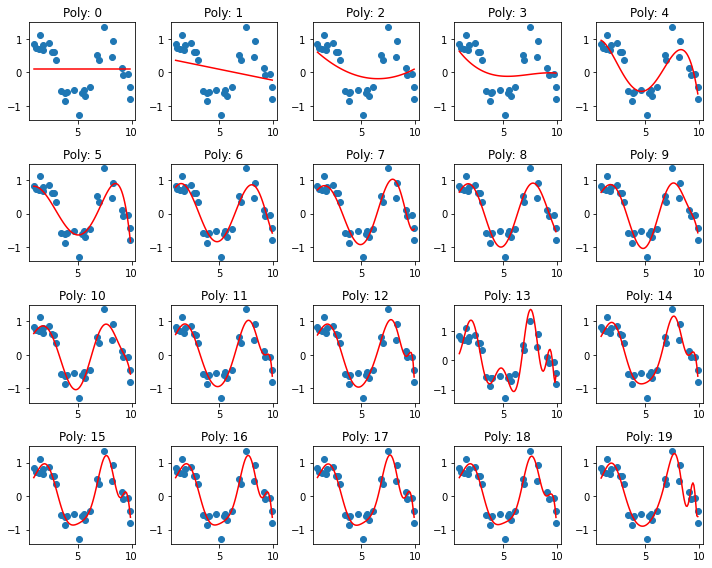

In [30]:
# TODO: Learn models and visualize regression lines
models = []
for degree in model_degrees:
    pr = PolyReg(d=degree, c=1)
    pr.fit(X, Y)
    models.append(pr)
    
nrows = (len(model_degrees) + 1) // 5
ncols = 5
fs = 2
plt.subplots(nrows=nrows, ncols=ncols, figsize=(fs*ncols, fs*nrows))
for i, (degree,pr) in enumerate(zip(model_degrees,models)):
    # Scatterplot
    ax = plt.subplot(nrows, ncols, i+1)
    ax.set_title(f"Poly: {degree}")
    ax.scatter(X, Y)

    # Prediction
    X_p = np.linspace(min(X), max(X), 100)
    preds = pr.predict(X_p)
    ax.plot(X_p, preds, color="r")
plt.tight_layout()

# TODO: What effect does c have on the regression lines?

## Model Validation
To evaluate the models, we need a measure of fit, that tells us how well the model fits the data. The standard measure for continuously distributed data is the ["root mean squared error" (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation). Given the dependent variable $Y \in \mathbb{R}^n$ and its prediction $\hat{Y} = f(X, \theta) \in \mathbb{R}^n$, the RMSE is defined as:

$$
\text{RMSE}(Y, \hat{Y}) = \sqrt{\frac{1}{n} \sum_{i}^n (Y_i - \hat{Y}_i)^2}
$$

### Task 6 (2 Points)
Implement a `rmse` function that returns the RMSE of a vector of observations $Y$ and its predictions $\hat{Y}$

In [27]:
def rmse(Y, Y_hat):
    # TODO: calculate RMSE
    return np.sqrt(np.mean((Y-Y_hat)**2))

Now we want to estimate which polynomial estimation fits best to our data.
More complex models will in general yield better results on the data that was used to train them, but the quality of the model is determined by its "generalizability" ("how well does the model perform on data that it has not seen before?"). 

To evaluate this performance, we split the data in two sets:
- trainset (`train.npy`)
- testset (`test.npy`)

where we train our predictor on the trainset and evaluate the generalizability on the testset.

### Task 7 (1 Point)

Load the testset (stored as `test.npy`).

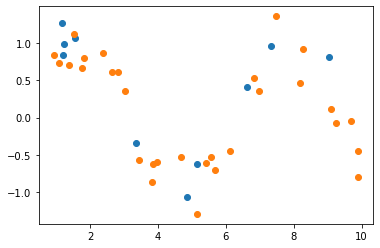

In [25]:
# TODO: load and standardize test data
data_test = np.load("test.npy")
X_test = data_test[:,0]
Y_test = data_test[:,1]

plt.scatter(X_test, Y_test)
plt.scatter(X, Y)

### Task 8 (2 Points)
To estimate the quality of our models:
- fit 20 polynomial models of degree 0 to 19 on the trainset.
- calculate the RMSE of all the models on the trainset.
- calculate the RMSE of all the models on the testset.

Set the regularization parameter to some fixed value.

In [35]:
# TODO: calculate train- and test RMSEs
model_degrees = np.arange(0, 20, 1)

train_rmse = []
test_rmse = []
for degree in model_degrees:
    pr = PolyReg(d=degree, c=0)
    pr.fit(X, Y)
    train_rmse.append(rmse(Y, pr.predict(X)))
    test_rmse.append(rmse(Y_test, pr.predict(X_test)))  

### Task 9 (1 Point)
Now visualize the training RMSE and testing RMSE in dependence of the degree of the models.

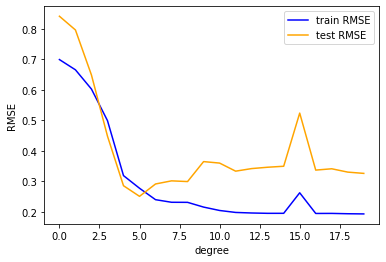

In [36]:
# TODO: plot RMSEs against polynomial degree
plt.plot(train_rmse, color="b", label="train RMSE")
plt.plot(test_rmse, color="orange", label="test RMSE")
plt.xlabel("degree")
plt.ylabel("RMSE")
plt.legend()

From the two curves of the previously generated figure you can determine the fit of the models.

- Underfitting: train- and test RMSE are high
- Overfitting: train RMSE is low, test RMSE is high
- Just right: train- and test RMSE are low

### Task 10 (1 Point)
List briefly:
- which models underfit
- which models overfit 

# Regularization on Housing Data

In this second part we want to explore the effect of regularization on the [Boston Housing dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). Each item in this dataset represents an area in Boston, Massachusetts.

Variables:

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per 10,000 Dollar
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
14. MEDV - Median value of owner-occupied homes in $1000's

The dataset is stored as a numpy array and thus without variable names. The i-th variable corresponds to the i-th column of the dataset.

### Task 11 (1 Point)

Load the Boston Housing Dataset stored in `housing.npy`, standardize it and split it into samples and labels.

In [37]:
# TODO: Load dataset
data = np.load('housing.npy')

# TODO: standardize 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data)
data_scaled = scaler.transform(data)

# TODO: split into features and labels
samples = data_scaled[:,:-1]
labels = data_scaled[:,-1]

Note, that our features are of a dimension $>1$ and therefore we cannot apply polynomial regression as introduced above. Therefore we will simply focus on linear regression with Ridge Regression again.

### Task 12 (1 Point)

Scikit-learn provides a [Ridge Regression class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) use it to fit a linear model on our data. Determine the RMSE on the whole dataset.

In [38]:
# TODO: use ridge regression from scikit learn
from sklearn.linear_model import Ridge
rr = Ridge(alpha=0)
rr.fit(samples, labels)
preds = rr.predict(samples)
rmse(preds, labels)

0.5092713774507562

You probably observed, that we still have no clue on how to set the regularization parameter $c$ ($\alpha$ in the scikit-learn implementation). One way to find good hyperparameters is by **crossvalidation**.

With [crossvalidation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), we want to assess how well a estimator can generalize on new, unseen data.

There are several types of crossvalidation, here we want to use **Leave One Out Crossvalidation** (LOOCV).

The principle is quite simple: For $m$ samples, we train $m$ estimators - each one taking a single sample for testing and the other samples for training. The average RMSE of all the estimators is then taken as an estimation for the quality of $c$.

### Task 13 (4 Points)

Implement a function `loocv`, that takes a Ridge Regression object (`estimator`), samples, labels and $k$ and outputs the cross_validation RMSE determined with the following steps:

1. For each sample:
    1. Use this sample as testdata, the other samples as traindata
    2. Learn estimator
    3. Estimate RMSE on testdata
2. Average estimated RMSEs

Test your function for $c=1$.

In [40]:
def loocv(estimator, samples, labels):
    # TODO: Implement leave one out crossvalidation for Ridge Regression
    rmses = []
    for i in range(samples.shape[0]):
        # select train and testset
        train_features = np.delete(samples, i, axis=0)
        train_labels =  np.delete(labels, i, axis=0)
        test_features = samples[i]
        test_labels = labels[i]
        
        # learn estimator
        estimator.fit(train_features, train_labels)
        test_preds = estimator.predict(test_features.reshape(1, -1))
        
        # calculate RMSE
        rmses.append(rmse(test_preds, test_labels))
        
    return np.mean(rmses)


estimator = Ridge(alpha=1)
loocv(estimator, samples, labels)

0.36772452981028064

### Task 14 (2 Points)
Now systematically test values for $c$ on their LOOCV performance.

What value for $c$ would you recommend?


Best c: 42


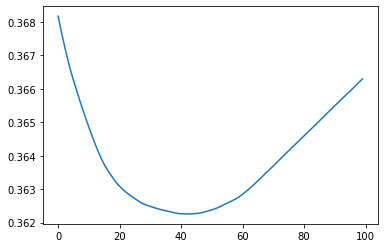

In [41]:
# TODO: LOOCV for different regularization parameters
from tqdm.notebook import tqdm
c_values = np.arange(0,100,1)
cvs = []
for c in tqdm(c_values):
    estimator = Ridge(alpha=c)
    cv = loocv(estimator, samples, labels)
    cvs.append(cv)
    
# TODO: What c would you recommend?
print(f'Best c: {c_values[np.argmin(cvs)]}')
plt.plot(c_values, cvs)